In [1]:
import polars as pl
import plotnine as pn

In [2]:
# Checking the current file location

#!dir

In [3]:
pitching = pl.read_csv("./Data/lahman_1871-2023_csv/Pitching.csv")
pitching.head()

playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
str,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""aardsda01""",2004,1,"""SFN""","""NL""",1,0,11,0,0,0,0,32,20,8,1,10,5,0.417,6.75,0,0,2,0,61,5,8,0,1,1
"""aardsda01""",2006,1,"""CHN""","""NL""",3,0,45,0,0,0,0,159,41,24,9,28,49,0.214,4.08,0,1,1,0,225,9,25,1,3,2
"""aardsda01""",2007,1,"""CHA""","""AL""",2,1,25,0,0,0,0,97,39,23,4,17,36,0.3,6.4,3,2,1,0,151,7,24,2,1,1
"""aardsda01""",2008,1,"""BOS""","""AL""",4,2,47,0,0,0,0,146,49,30,4,35,49,0.268,5.55,2,3,5,0,228,7,32,3,2,4
"""aardsda01""",2009,1,"""SEA""","""AL""",3,6,73,0,0,0,38,214,49,20,4,34,80,0.19,2.52,3,2,0,0,296,53,23,2,1,2


In [4]:
# There are 7 types of leagues 

pitching['lgID'].unique().to_list()

['UA', 'PL', 'NL', 'AA', 'NA', 'FL', 'AL']

In [5]:
# Part1 - Q5

league_ERA = (pitching
              .select(['yearID','lgID','ER','IPouts'])
              .filter(pl.col('yearID') >= 1946)
              .filter(pl.col('lgID').is_in(['AL','NL']))
              .group_by(['yearID','lgID'])
              .agg(pl.col('ER').sum().alias('total_runs'),
                   pl.col('IPouts').sum().alias('total_outs')
                  )
              .with_columns(league_ERA = (pl.col('total_runs')/pl.col('total_outs'))*27)
              .sort(pl.col('yearID'))
             )
league_ERA.head()

yearID,lgID,total_runs,total_outs,league_ERA
i64,str,i64,i64,f64
1946,"""NL""",4202,33254,3.41174
1946,"""AL""",4306,33186,3.503345
1947,"""AL""",4560,33228,3.705309
1947,"""NL""",4956,32902,4.066987
1948,"""AL""",5223,32929,4.282578


In [6]:
# Part1 - Q6

DH_rule = (league_ERA
             .select(['yearID','lgID','total_runs','total_outs','league_ERA'])
             .with_columns(DH_rule = pl.when((pl.col('yearID') < 1973) & (pl.col('lgID') == 'AL'))
                                       .then(pl.lit('No'))
                                       .otherwise(pl.lit('Yes'))
                          )
             .with_columns(DH_rule = pl.when((pl.col('yearID') >= 2022) & (pl.col('yearID') == 2020) & (pl.col('lgID') == 'NL'))
                                       .then(pl.lit('Yes'))
                                       .otherwise(pl.lit('No'))
                          )
            )
DH_rule.head()

yearID,lgID,total_runs,total_outs,league_ERA,DH_rule
i64,str,i64,i64,f64,str
1946,"""NL""",4202,33254,3.41174,"""No"""
1946,"""AL""",4306,33186,3.503345,"""No"""
1947,"""AL""",4560,33228,3.705309,"""No"""
1947,"""NL""",4956,32902,4.066987,"""No"""
1948,"""AL""",5223,32929,4.282578,"""No"""


In [7]:
DH_rule.write_csv("./Data/DH_rule.csv")

In [8]:
new_DH_rule = (DH_rule
               .select(['yearID','lgID','league_ERA'])
               .with_row_index('ID', offset=1)
              )
new_DH_rule.head()

ID,yearID,lgID,league_ERA
u32,i64,str,f64
1,1946,"""NL""",3.41174
2,1946,"""AL""",3.503345
3,1947,"""AL""",3.705309
4,1947,"""NL""",4.066987
5,1948,"""AL""",4.282578


In [9]:
unstack = (new_DH_rule
           .pivot('lgID',
                  index = 'yearID',
                  values = 'league_ERA'
                 )
          )
unstack.head()

yearID,NL,AL
i64,f64,f64
1946,3.41174,3.503345
1947,4.066987,3.705309
1948,3.954666,4.282578
1949,4.040309,4.197697
1950,4.14127,4.576758


In [10]:
new_column = (unstack
             .with_columns(AL_NL = pl.col('AL') - pl.col('NL'))
             )
new_column.head()

yearID,NL,AL,AL_NL
i64,f64,f64,f64
1946,3.41174,3.503345,0.091605
1947,4.066987,3.705309,-0.361678
1948,3.954666,4.282578,0.327912
1949,4.040309,4.197697,0.157388
1950,4.14127,4.576758,0.435488


In [11]:
league_type = ['AL','NL','AL_NL']

stack = (new_column
        .unpivot(league_type,
                 index = 'yearID',
                 variable_name = 'League',
                 value_name = 'League_ERA'
                )
        )
stack.head()

yearID,League,League_ERA
i64,str,f64
1946,"""AL""",3.503345
1947,"""AL""",3.705309
1948,"""AL""",4.282578
1949,"""AL""",4.197697
1950,"""AL""",4.576758


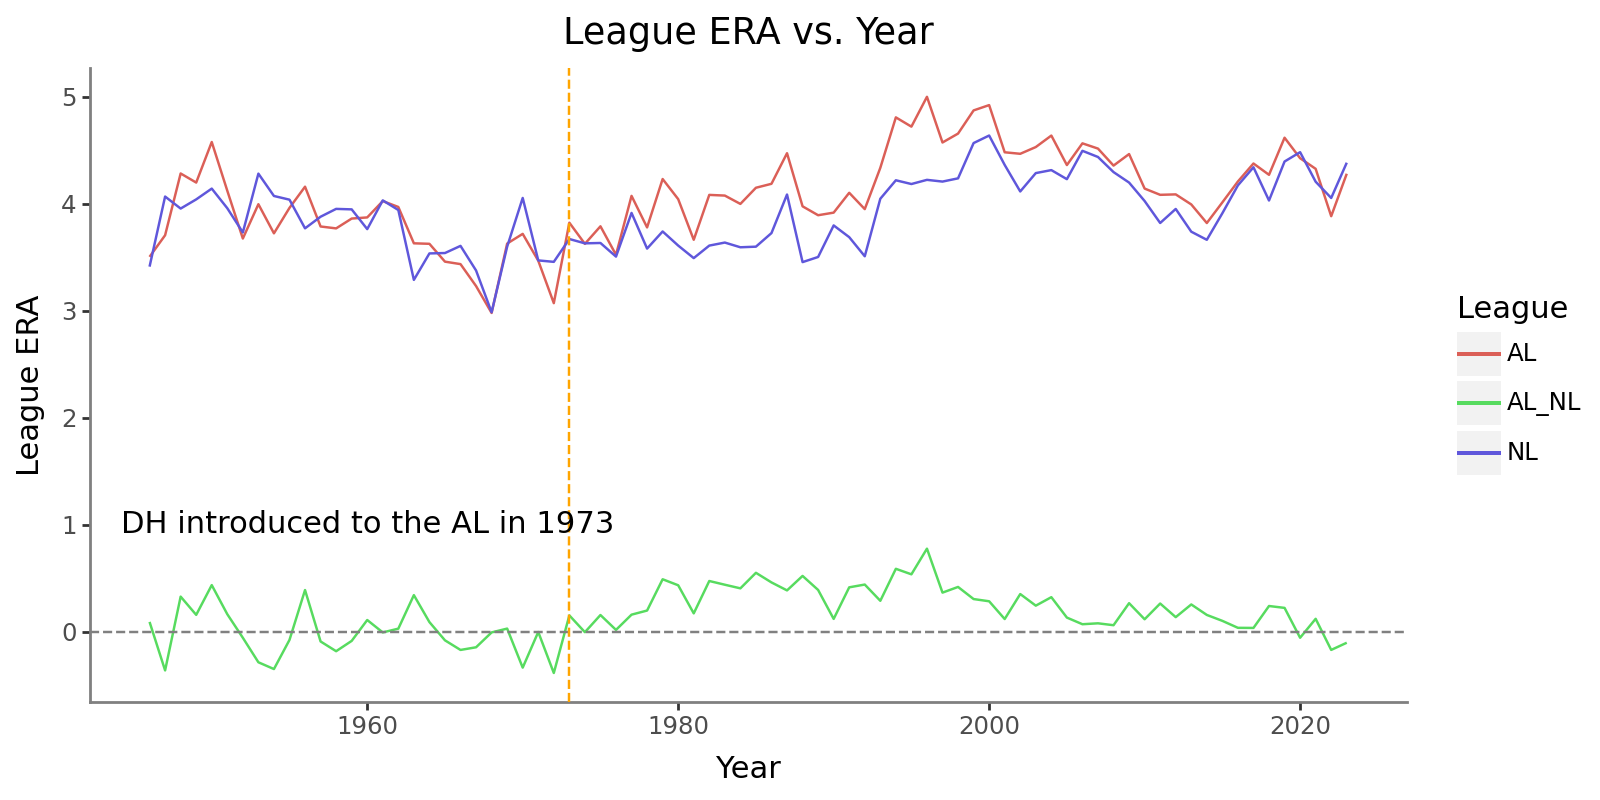

In [51]:
#This code expands the default plot size:
pn.options.figure_size = (8, 4)

from plotnine import ggplot, geom_line, geom_hline, geom_vline, aes, annotate, ggtitle, xlab, ylab, theme, element_blank, element_line

plot1 = (ggplot(data = stack)
         + geom_line(aes(x = "yearID",   
                         y = "League_ERA",
                         color = "League"))
         + geom_hline(yintercept = 0,
                      color = 'gray',
                      linetype="dashed")
         + geom_vline(xintercept = 1973,
                      color = 'orange',
                      linetype="dashed"
                     )
         + annotate('text', x=1960, y = 1, label='DH introduced to the AL in 1973')
         + ggtitle('League ERA vs. Year')
         + xlab('Year')
         + ylab('League ERA')
         + theme(panel_background=element_blank(),
                 axis_line_x = element_line(color='gray'),
                 axis_line_y = element_line(color='gray')
                )
        )
plot1

In [55]:
plot1.save(filename = 'plot1.png', dpi=300)

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars2\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 4 in image.
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars2\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: plot1.png


In [13]:
batting = pl.read_csv("./Data/lahman_1871-2023_csv/Batting.csv")
batting.head()

playerID,yearID,stint,teamID,lgID,G,G_batting,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,G_old
str,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
"""aardsda01""",2004,1,"""SFN""","""NL""",11,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null
"""aardsda01""",2006,1,"""CHN""","""NL""",45,null,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,null
"""aardsda01""",2007,1,"""CHA""","""AL""",25,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null
"""aardsda01""",2008,1,"""BOS""","""AL""",47,null,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,null
"""aardsda01""",2009,1,"""SEA""","""AL""",73,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null


In [14]:
# Part2 

SLG = (batting
      .select(['yearID','lgID','AB','H','2B','3B','HR'])
      .filter((pl.col('yearID') >= 1946) &
               (pl.col('lgID').is_in(['AL','NL']))
             )
      .group_by(['yearID','lgID'])
      .agg((pl.col('H').sum() + pl.col('2B').sum()*2 + pl.col('3B').sum()*3 + pl.col('HR').sum()*4).alias('numerator'),
           (pl.col('AB').sum()).alias('denominator')
          )
      .with_columns(SLG = pl.col('numerator')/pl.col('denominator'))
      .sort(pl.col('yearID'))
      )
SLG.head()

yearID,lgID,numerator,denominator,SLG
i64,str,i64,i64,f64
1946,"""AL""",18262,42239,0.432349
1946,"""NL""",17660,42094,0.419537
1947,"""NL""",19704,42434,0.464345
1947,"""AL""",18107,42002,0.431099
1948,"""NL""",19234,42256,0.455178


In [15]:
SLG.write_csv("./data/SLG.csv")

In [16]:
new_SLG = (SLG
               .select(['yearID','lgID','SLG'])
               .with_row_index('ID', offset=1)
              )
new_SLG.head()

ID,yearID,lgID,SLG
u32,i64,str,f64
1,1946,"""AL""",0.432349
2,1946,"""NL""",0.419537
3,1947,"""NL""",0.464345
4,1947,"""AL""",0.431099
5,1948,"""NL""",0.455178


In [17]:
unstack_SLG = (new_SLG
               .pivot('lgID',
                  index = 'yearID',
                  values = 'SLG'
                 )
          )
unstack_SLG.head()

yearID,AL,NL
i64,f64,f64
1946,0.432349,0.419537
1947,0.431099,0.464345
1948,0.452947,0.455178
1949,0.448391,0.463276
1950,0.478529,0.480125


In [56]:
new_column_SLG = (unstack_SLG
                  .with_columns(AL_NL = pl.col('AL') - pl.col('NL'))
                 )
new_column_SLG.head()

yearID,AL,NL,AL_NL
i64,f64,f64,f64
1946,0.432349,0.419537,0.012812
1947,0.431099,0.464345,-0.033246
1948,0.452947,0.455178,-0.002231
1949,0.448391,0.463276,-0.014886
1950,0.478529,0.480125,-0.001596


In [58]:
league_type = ['AL','NL','AL_NL']

stack_SLG = (new_column_SLG
        .unpivot(league_type,
                 index = 'yearID',
                 variable_name = 'League',
                 value_name = 'SLG'
                )
        )
stack_SLG.head()

yearID,League,SLG
i64,str,f64
1946,"""AL""",0.432349
1947,"""AL""",0.431099
1948,"""AL""",0.452947
1949,"""AL""",0.448391
1950,"""AL""",0.478529


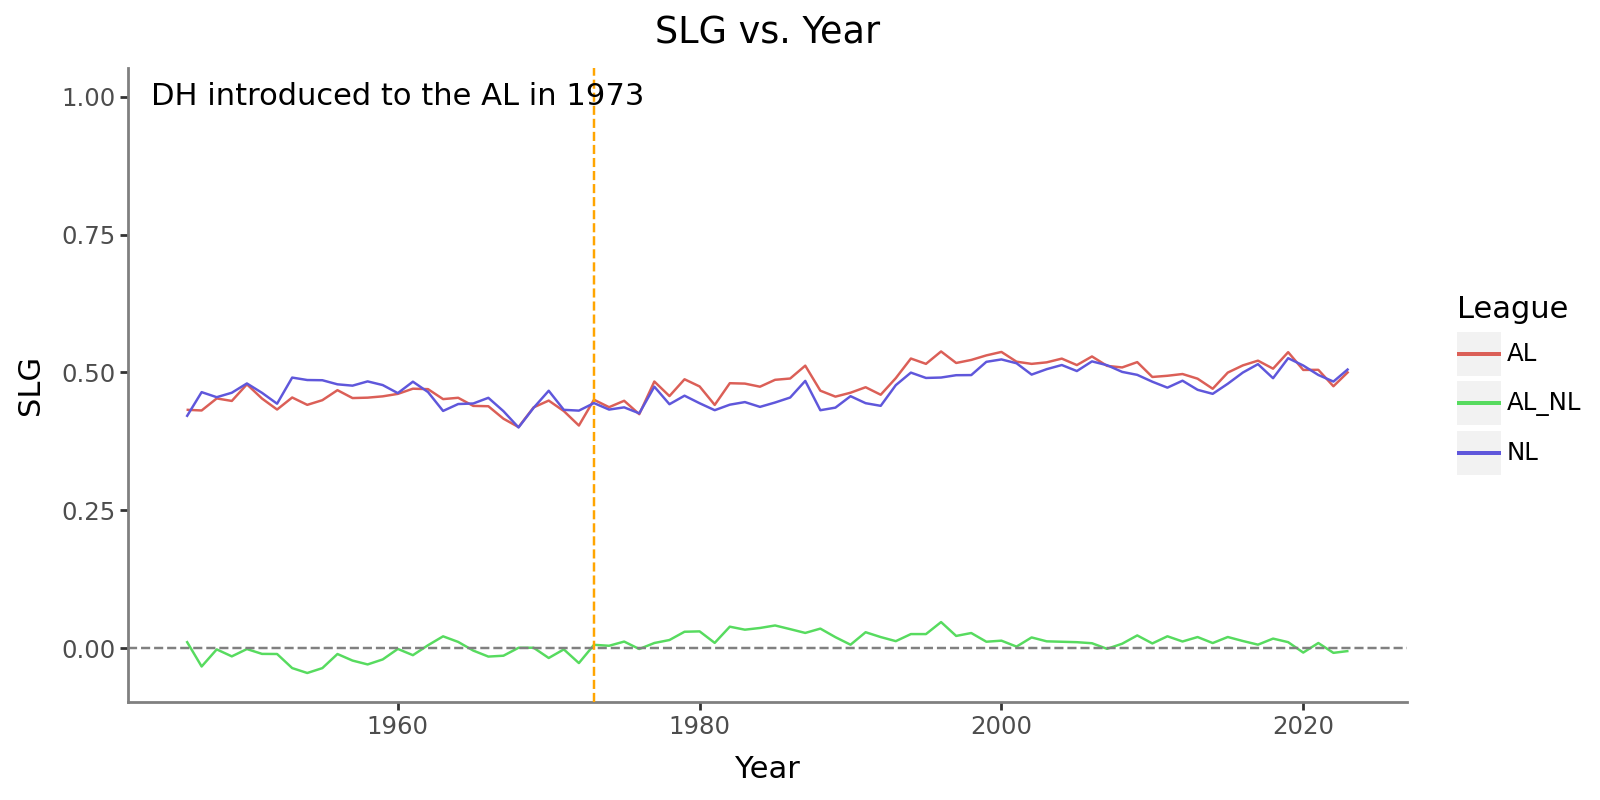

In [59]:
from plotnine import ggplot, geom_line, geom_hline, geom_vline, aes, annotate, ggtitle, xlab, ylab, theme, element_blank, element_line


plot2 = (ggplot(data = stack_SLG)
         + geom_line(aes(x = "yearID",   
                         y = "SLG",
                         color = "League"))
         + geom_hline(yintercept = 0,
                      color = 'gray',
                      linetype="dashed")
         + geom_vline(xintercept = 1973,
                      color = 'orange',
                      linetype="dashed"
                     )
         + annotate('text', x=1960, y = 1, label='DH introduced to the AL in 1973')
         + ggtitle('SLG vs. Year')
         + xlab('Year')
         + ylab('SLG')
         + theme(panel_background=element_blank(),
                 axis_line_x = element_line(color='gray'),
                 axis_line_y = element_line(color='gray')
                )
        )
plot2

In [64]:
plot2.save(filename = 'plot2.png', dpi=300)

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars2\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 4 in image.
C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars2\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: plot2.png
